In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

In [2]:
us = pd.read_csv("US_youtube_trending_data.csv")
in_data = pd.read_csv("IN_youtube_trending_data.csv")

In [3]:
us['region'] = 'US'
in_data['region'] = 'IN'

In [4]:
common_cols = list(set(us.columns).intersection(in_data.columns))
df = pd.concat([us[common_cols], in_data[common_cols]], ignore_index=True)

In [5]:
df.columns

Index(['description', 'likes', 'publishedAt', 'categoryId', 'tags', 'dislikes',
       'comment_count', 'region', 'comments_disabled', 'channelTitle',
       'view_count', 'thumbnail_link', 'title', 'video_id', 'ratings_disabled',
       'channelId', 'trending_date'],
      dtype='object')

In [6]:
df.rename(columns={
    'publishedAt': 'publish_time',
    'categoryId': 'category_id',
    'view_count': 'views'
}, inplace=True)

In [7]:
df['trending_date'] = pd.to_datetime(df['trending_date'])
df['publish_time'] = pd.to_datetime(df['publish_time'])

In [8]:
import json 

with open('US_category_id.json') as f:
    category_data = json.load(f)

category_mapping = {
    int(item['id']): item['snippet']['title']
    for item in category_data['items']
}

df['category'] = df['category_id'].map(category_mapping)

In [9]:
df['title_sentiment'] = df['title'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
df['tags_sentiment'] = df['tags'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

In [10]:
def categorize_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['title_sentiment'].apply(categorize_sentiment)

In [11]:
trending_days = df.groupby('video_id')['trending_date'].nunique().reset_index()
trending_days.columns = ['video_id', 'days_trending']

df = df.merge(trending_days, on='video_id')

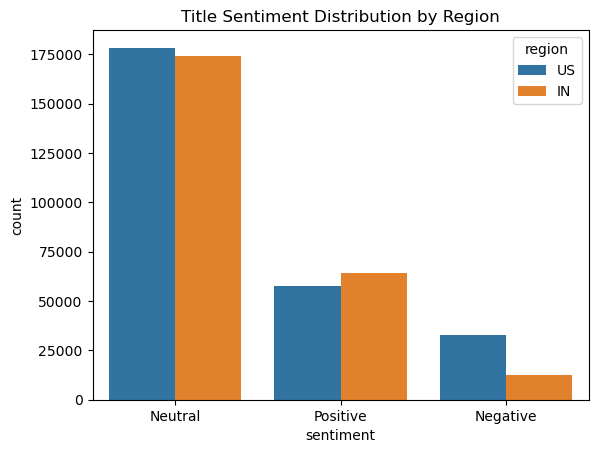

In [12]:
sns.countplot(data=df, x='sentiment', hue='region')
plt.title("Title Sentiment Distribution by Region")
plt.show()

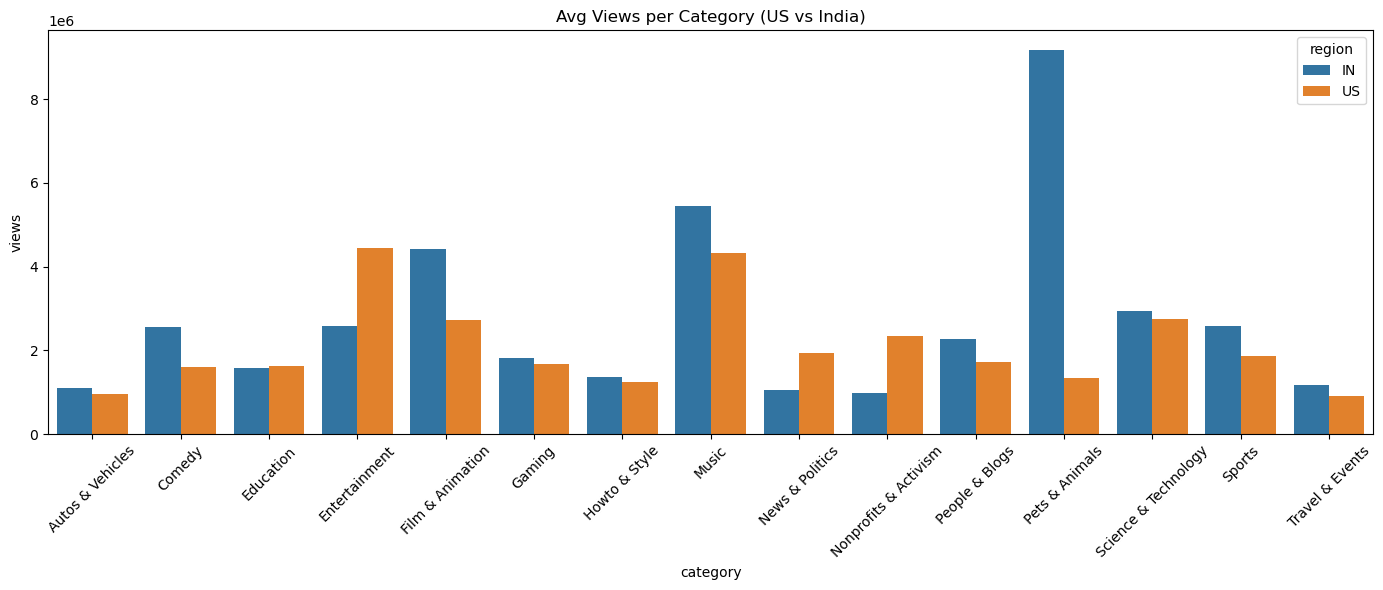

In [13]:
avg_views = df.groupby(['region', 'category'])['views'].mean().reset_index()

plt.figure(figsize=(14,6))
sns.barplot(data=avg_views, x='category', y='views', hue='region')
plt.title("Avg Views per Category (US vs India)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

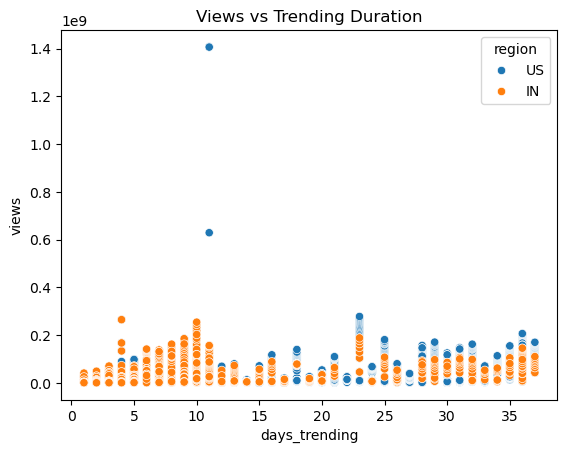

In [14]:
sns.scatterplot(data=df, x='days_trending', y='views', hue='region')
plt.title("Views vs Trending Duration")
plt.show()

In [15]:
df.to_csv("cleaned_youtube_us_india.csv", index=False)

## SQL Queries

In [32]:
import sqlite3

In [34]:
conn = sqlite3.connect("youtube.db")

In [36]:
df.to_sql("videos", conn, if_exists='replace', index=False)

520064

In [54]:
top_viewed = pd.read_sql_query("""
SELECT region, category, AVG(views) AS avg_views
FROM videos
GROUP BY region, category
ORDER BY region, avg_views DESC
""", conn)

top_viewed.head(20)

,region,category,avg_views
0,IN,Pets & Animals,9.188948e+06
1,IN,Music,5.450439e+06
2,IN,Film & Animation,4.421432e+06
3,IN,Science & Technology,2.933895e+06
4,IN,Entertainment,2.589086e+06
5,IN,Sports,2.586412e+06
6,IN,Comedy,2.567720e+06
7,IN,People & Blogs,2.273180e+06
8,IN,Gaming,1.818622e+06
9,IN,Education,1.572298e+06


In [56]:
top_liked = pd.read_sql_query("""
SELECT region, category, AVG(likes) AS avg_likes
FROM videos
GROUP BY region, category
ORDER BY region, avg_likes DESC
""", conn)

top_liked.head(20)

,region,category,avg_likes
0,IN,Pets & Animals,518105.372727
1,IN,Music,271964.260204
2,IN,Science & Technology,197155.173540
3,IN,Comedy,183298.212063
4,IN,Gaming,148083.826400
5,IN,People & Blogs,142163.259938
6,IN,Film & Animation,119583.588199
7,IN,Entertainment,105365.492429
8,IN,Education,88545.218304
9,IN,Travel & Events,86066.337033


In [72]:
top_trending = pd.read_sql_query("""
SELECT title, category,
       MAX(region) AS region,
       MAX(days_trending) AS days_trending, 
       MAX(views) AS views
FROM videos
GROUP BY title, category
ORDER BY days_trending DESC
LIMIT 10;
""", conn)

top_trending

,title,category,region,days_trending,views
0,"$1 Vs $100,000,000 House!",Entertainment,US,37,114568042
1,"$1 vs $100,000,000 House!",Entertainment,US,37,136655670
2,"$10,000 Every Day You Survive In A Grocery Store",Entertainment,US,37,161203338
3,"Face Your Biggest Fear To Win $800,000",Entertainment,US,37,169649341
4,"Every Country On Earth Fights For $250,000!",Entertainment,US,36,124883244
5,Grand Theft Auto VI Trailer 1,Gaming,US,36,166323421
6,I Survived 7 Days In An Abandoned City,Entertainment,US,36,157124797
7,"India claim stunning series win, end Australia...",Sports,US,36,38392855
8,"Survive 100 Days Trapped, Win $500,000",Entertainment,US,36,158127636
9,Turn into orbeez - Tutorial #Shorts,Entertainment,US,36,206202284
